In [1]:
import torch
from transformers import BertTokenizer, BertModel

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
#logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt
# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('./bert-tokenizer-bangla')

In [2]:
tokenizer.convert_ids_to_tokens(3000)


'##মাতে'

In [23]:
text = "কিন্তু আপনি যদি এই ফলের পোশাক পছন্দ না করেন"
marked_text = "[CLS] " + text + " [SEP]"

# Tokenize our sentence with the BERT tokenizer.
tokenized_text = tokenizer.tokenize(marked_text)

# Print out the tokens.
print (tokenized_text)

['[CLS]', 'কিনত', 'আপনি', 'যদি', 'এই', 'ফলের', 'পোশাক', 'পছনদ', 'না', 'করেন', '[SEP]']


In [4]:
list(tokenizer.vocab.keys())[5000:5020]

['মাঝামা',
 '##ংকং',
 'আবহাওযা',
 '৩০০',
 '##বযে',
 'সমপ',
 'জনমের',
 '##ওযারড',
 'উপে',
 'তলেছিল',
 'এতই',
 'বৈদযতিক',
 'মাঝামাঝি',
 'ঋণ',
 'পতা',
 '##উনি',
 '##িনির',
 '##তনতরের',
 'পরেকষ',
 'পদে']

In [24]:
# Define a new example sentence with multiple meanings of the word "bank"
text = "টাকশাল, ধনিয়া, ল্যাভেন্ডার, বুরগামট, লেবু ইত্যাদির গন্ধ"


# Add the special tokens.
marked_text = "[CLS] " + text + " [SEP]"

# Split the sentence into tokens.
tokenized_text = tokenizer.tokenize(marked_text)

# Map the token strings to their vocabulary indeces.
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

# Display the words with their indeces.
for tup in zip(tokenized_text, indexed_tokens):
    print('{:<12} {:>6,}'.format(tup[0], tup[1]))

[CLS]             2
টাক          19,568
##শাল         1,208
,                15
ধন            6,502
##িযা           557
,                15
লযাভেন       29,343
##ডার           822
,                15
বরগা         22,435
##মট         28,935
,                15
লেব          21,137
ইতযাদির       7,964
গনধ           5,141
[SEP]             3


In [25]:
# Mark each of the 22 tokens as belonging to sentence "1".
segments_ids = [1] * len(tokenized_text)

print (segments_ids)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [26]:
# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

In [27]:
# Load pre-trained model (weights)
model = BertModel.from_pretrained('./bert-encoder',
                                  output_hidden_states = True, # Whether the model returns all hidden-states.
                                  )

# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [28]:
# Run the text through BERT, and collect all of the hidden states produced
# from all 12 layers. 
with torch.no_grad():

    outputs = model(tokens_tensor, segments_tensors)

    # Evaluating the model will return a different number of objects based on 
    # how it's  configured in the `from_pretrained` call earlier. In this case, 
    # becase we set `output_hidden_states = True`, the third item will be the 
    # hidden states from all layers. See the documentation for more details:
    # https://huggingface.co/transformers/model_doc/bert.html#bertmodel
    hidden_states = outputs[2]

In [29]:
print ("Number of layers:", len(hidden_states), "  (initial embeddings + 12 BERT layers)")
layer_i = 0

print ("Number of batches:", len(hidden_states[layer_i]))
batch_i = 0

print ("Number of tokens:", len(hidden_states[layer_i][batch_i]))
token_i = 0

print ("Number of hidden units:", len(hidden_states[layer_i][batch_i][token_i]))

Number of layers: 13   (initial embeddings + 12 BERT layers)
Number of batches: 1
Number of tokens: 17
Number of hidden units: 768


In [30]:
token_i = 5
layer_i = 5
vec = hidden_states[layer_i][batch_i][token_i]

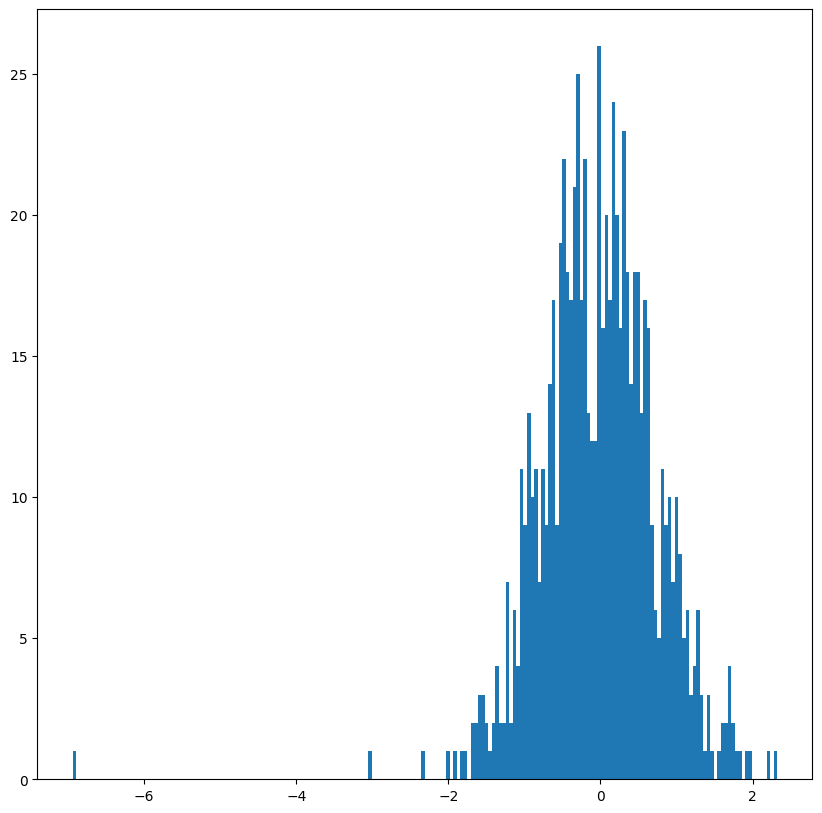

In [31]:
plt.figure(figsize=(10,10))
plt.hist(vec, bins=200)
plt.show()

In [32]:
# `hidden_states` is a Python list.
print('      Type of hidden_states: ', type(hidden_states))

# Each layer in the list is a torch tensor.
print('Tensor shape for each layer: ', hidden_states[0].size())

      Type of hidden_states:  <class 'tuple'>
Tensor shape for each layer:  torch.Size([1, 17, 768])


In [33]:
# Concatenate the tensors for all layers. We use `stack` here to
# create a new dimension in the tensor.
token_embeddings = torch.stack(hidden_states, dim=0)

token_embeddings.size()

torch.Size([13, 1, 17, 768])

In [34]:
# Remove dimension 1, the "batches".
token_embeddings = torch.squeeze(token_embeddings, dim=1)

token_embeddings.size()

torch.Size([13, 17, 768])

In [35]:
# Swap dimensions 0 and 1.
token_embeddings = token_embeddings.permute(1,0,2)

token_embeddings.size()

torch.Size([17, 13, 768])

In [36]:
# Stores the token vectors, with shape [22 x 3,072]
token_vecs_cat = []

# `token_embeddings` is a [22 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:
    
    # `token` is a [12 x 768] tensor

    # Concatenate the vectors (that is, append them together) from the last 
    # four layers.
    # Each layer vector is 768 values, so `cat_vec` is length 3,072.
    cat_vec = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)
    
    # Use `cat_vec` to represent `token`.
    token_vecs_cat.append(cat_vec)

print ('Shape is: %d x %d' % (len(token_vecs_cat), len(token_vecs_cat[0])))

Shape is: 17 x 3072


In [37]:
# Stores the token vectors, with shape [22 x 768]
token_vecs_sum = []

# `token_embeddings` is a [22 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:

    # `token` is a [12 x 768] tensor

    # Sum the vectors from the last four layers.
    sum_vec = torch.sum(token[-4:], dim=0)
    
    # Use `sum_vec` to represent `token`.
    token_vecs_sum.append(sum_vec)

print ('Shape is: %d x %d' % (len(token_vecs_sum), len(token_vecs_sum[0])))

Shape is: 17 x 768


In [38]:
for i, token_str in enumerate(tokenized_text):
  print (i, token_str)

0 [CLS]
1 টাক
2 ##শাল
3 ,
4 ধন
5 ##িযা
6 ,
7 লযাভেন
8 ##ডার
9 ,
10 বরগা
11 ##মট
12 ,
13 লেব
14 ইতযাদির
15 গনধ
16 [SEP]


In [40]:
print('First 5 vector values for each instance of "bank".')
print('')
print("bank vault   ", str(token_vecs_sum[6][:5]))
print("bank robber  ", str(token_vecs_sum[10][:5]))
print("river bank   ", str(token_vecs_sum[19][:5]))

First 5 vector values for each instance of "bank".

bank vault    tensor([-2.1324,  0.6233, -3.6257,  2.1548,  0.9334])
bank robber   tensor([ 0.9173,  1.8626, -3.3767,  2.1601, -0.8723])


IndexError: list index out of range

In [21]:
len(token_vecs_sum[0])

768

In [22]:
from scipy.spatial.distance import cosine

# Calculate the cosine similarity between the word bank 
# in "bank robber" vs "river bank" (different meanings).
diff_bank = 1 - cosine(token_vecs_sum[10], token_vecs_sum[19])

# Calculate the cosine similarity between the word bank
# in "bank robber" vs "bank vault" (same meaning).
same_bank = 1 - cosine(token_vecs_sum[10], token_vecs_sum[6])

print('Vector similarity for  *similar*  meanings:  %.2f' % same_bank)
print('Vector similarity for *different* meanings:  %.2f' % diff_bank)

Vector similarity for  *similar*  meanings:  0.92
Vector similarity for *different* meanings:  0.83
